# Kaggle - Store Item Demand Forecasting Challenge

This project is based on the kaggle competittion _[Store Item Demand Forecasting Challenge](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview)_. All data used can be found in there.

The project can be summarized as: Given 5 years of store-item sales data, predict 3 months of sales for 50 different items at 10 different stores.
***

## Exploring the Data

### Import packages

Let's start with the basics: importing the necessary libraries.

In [2]:
# Necessary Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from time import time
import statsmodels.api as sm
from IPython.display import display # Allows the use of display() for DataFrames.

# Visualiation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Improves display for notebooks
%matplotlib inline

### Load and check data

Now let's read and take a look at the training and test data.

In [3]:
# Load the training dataset and convert de date column do date format
df_train = pd.read_csv('train.csv', parse_dates=['date'])

# Display the first record
display(df_train.head(n=1))

,date,store,item,sales
0,2013-01-01,1,1,13


As shown, it's a timeseries problem containing other 2 features, store and item,  and 1 target, which is the sales column.

Let's take a look at the test dataset.

In [4]:
df_test = pd.read_csv('test.csv', parse_dates=['date'])
display(df_test.head(n=1))

,id,date,store,item
0,0,2018-01-01,1,1


The test dataset looks exactly like de train dataset but without the target column. An id column appeared before the date column but we will discuss that later.

Every kaggle competition provides a sample submission file. This file shows the correct format and structure of the submission. It's a good practice to look at this file in the beggining of the project to get to know what's the output should look like.

In [5]:
sample_sub = pd.read_csv('sample_submission.csv')
display(sample_sub.head())

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


It consists of two columns, the item id and the 2018's first quarter sales.

It's time to get some info from the train and test datasets

In [6]:
# Getting the unique stores, item and dates
s_train, s_test = df_train.store.unique(), df_test.store.unique()
i_train, i_test = df_train.item.unique(), df_test.item.unique()
dates_train, dates_test = df_train.date.unique(), df_test.date.unique()

print('Train dataset:')
print('Entries: ', len(df_train))
print('Stores: {} - {}'.format(s_train[0], s_train[-1]))
print('Items: {} - {}'.format(i_train[0], i_train[-1]))
print('Dates: {:.10} - {:.10}'.format(dates_train[0], dates_train[-1]))
print('')
print('Test dataset')
print('Entries: ', len(df_test))
print('Stores: {} - {}'.format(s_test[0], s_test[-1]))
print('Items: {} - {}'.format(i_test[0], i_test[-1]))
print('Dates: {:.10} - {:.10}'.format(dates_test[0], dates_test[-1]))

Train dataset:
Entries:  913000
Stores: 1 - 10
Items: 1 - 50
Dates: 2013-01-01 - 2017-12-31

Test dataset
Entries:  45000
Stores: 1 - 10
Items: 1 - 50
Dates: 2018-01-01 - 2018-03-31


It is also easy to check the max a min values for store and items by using the .describe() method. This method also helps to identify outliers.

In [7]:
df_train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
df_test.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


The .info() method could also be used to get the entries number and to check if there is any empty or null values.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


The data seems to be clean. If there is any quirks in data it's gonna be catched later, during the data analysis.

### Plot data

In order to understand the data and confirm if there is any outliers or other "messy" values the data is gonna be plotted. The first plot will also gives some general ideas about the data.

Let's first plot it as it comes, using item 1 and 2 and store 1 and 2, and sees if its necessary to make any modifications in order to make it more readable.

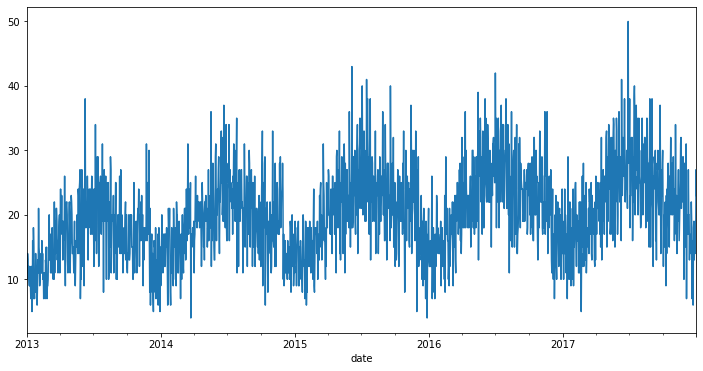

In [11]:
# Creating an "empty" plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the store and item combination [1,1]
df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 1)].set_index('date')['sales'].plot()

As seen the data could be more undestanble if resampled by week, for example.

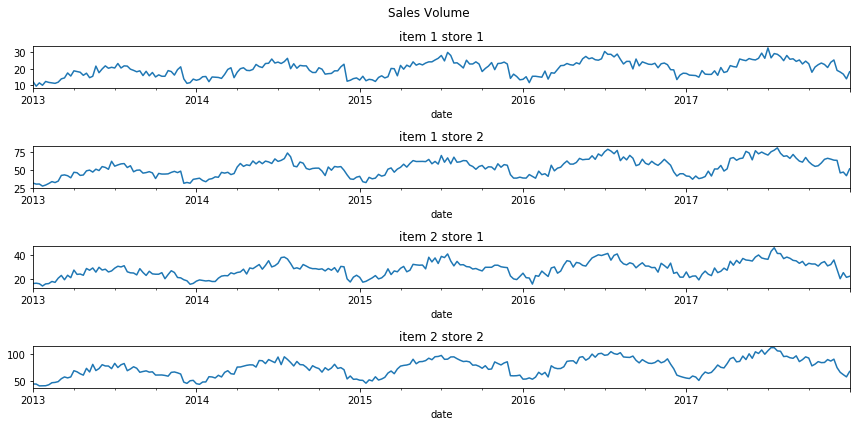

In [12]:
# Creating an "empty" plot with 4 ax's
fig, ax = plt.subplots(4, figsize=(12, 6))

# Plot all combinations for item = [1,2] and store = [1,2] resample by week by its mean
df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 1)].set_index('date')['sales'].resample('W').mean().plot(ax = ax[0])
df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 2)].set_index('date')['sales'].resample('W').mean().plot(ax = ax[1])
df_train.loc[(df_train['store'] == 2) & (df_train['item'] == 1)].set_index('date')['sales'].resample('W').mean().plot(ax = ax[2])
df_train.loc[(df_train['store'] == 2) & (df_train['item'] == 2)].set_index('date')['sales'].resample('W').mean().plot(ax = ax[3])

# Setting titles for each plot
ax[0].set_title('item {} store {}'.format(1, 1))
ax[1].set_title('item {} store {}'.format(1, 2))
ax[2].set_title('item {} store {}'.format(2, 1))
ax[3].set_title('item {} store {}'.format(2, 2))

# Setting general title
fig.suptitle('Sales Volume')

# Improving plot layout since titles gets overlapping the graph area
fig.tight_layout(rect=[0, 0, 1, 0.95])

By these plots it's easy to identify some trends and __seasonalities__ patterns, having peaks during the summer. It can also be noticed the __correlation__ between stores. Let's check if those are true and if it propagates over other stores.

### Correlation, seasonality and trend

First the correlation:

Minimum corr:  0.9243474004180068


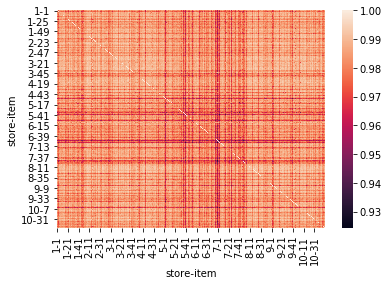

In [13]:
# Reshaped the dataframe in order to make the correlation, putting each store and item as columns
grouped_dftrain = df_train.pivot_table(index='date', columns=['store', 'item'], values='sales')

# Resample by month
grouped_dftrain = grouped_dftrain.resample('M').mean() # We could use the .pct_change() method in order to compute the correlation by percent change. The correlation is also high

corr = grouped_dftrain.corr(method='pearson')
sns.heatmap(corr)
print('Minimum corr: ',corr.min(axis=0).min())

Having correlations greater than .92 shows what was visible in the last graph.

Let's see if there is trends and seasonalities:

In [14]:
# Creating columns to plot seasonality by year, month, etc.
season_dftrain = df_train.copy()
season_dftrain['Year'] = season_dftrain.date.dt.year
season_dftrain['Month'] = season_dftrain.date.dt.month
season_dftrain['Day'] = season_dftrain.date.dt.day
season_dftrain['Dayofweek'] = season_dftrain.date.dt.dayofweek

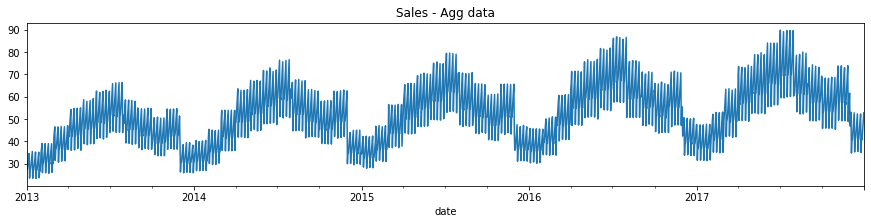

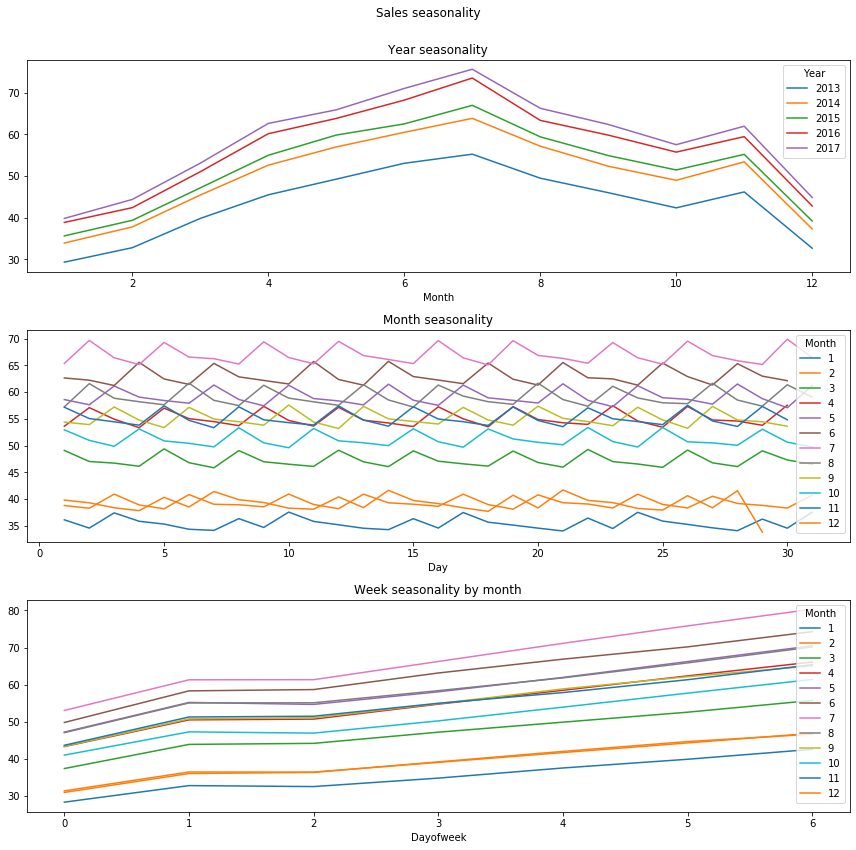

In [15]:
# Plotting sales aggregated by date
df_train.groupby('date').mean()['sales'].plot(figsize=(15,3), title='Sales - Agg data')
fig, ax = plt.subplots(3, figsize=(12, 12))

# Plotting seasonalities
_ = pd.pivot_table(season_dftrain, values='sales', columns='Year', index='Month').plot(title='Year seasonality', ax=ax[0])
_ = pd.pivot_table(season_dftrain, values='sales', columns='Month', index='Day').plot(title='Month seasonality', ax=ax[1])
_ = pd.pivot_table(season_dftrain, values='sales', columns='Month', index='Dayofweek').plot(title='Week seasonality by month', ax=ax[2])

fig.suptitle('Sales seasonality')
fig.tight_layout(rect=[0, 0, 1, 0.95])

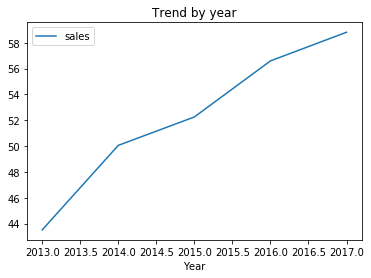

In [16]:
# Plotting the trend
_ = pd.pivot_table(season_dftrain, values='sales', index='Year').plot(title='Trend by year')

By these last plots we could confirm a seasonality over the data and an upward trend.

There is the seasonal decompose that could be used to identify seasonality and trend as well

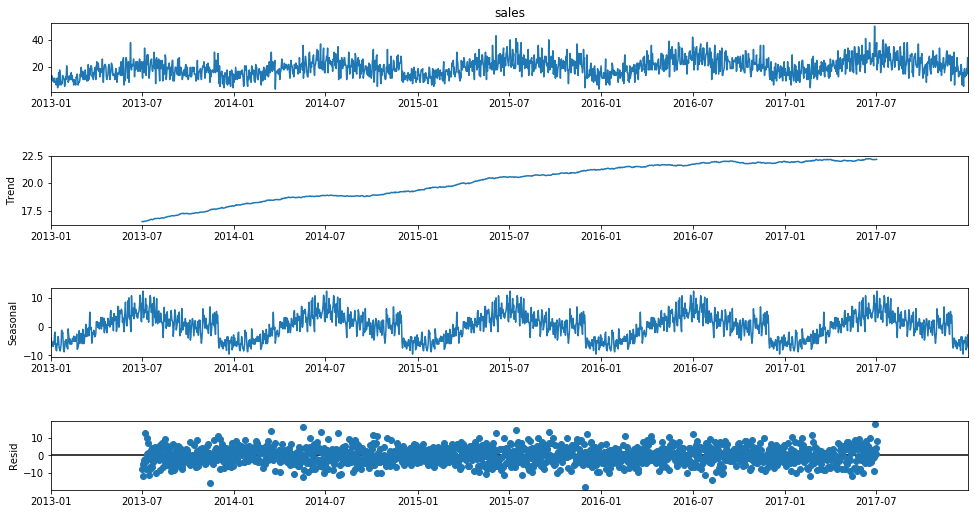

In [18]:
# First lets take de data for item = 1 and store = 1
aux = season_dftrain[(season_dftrain.item == 1) & (season_dftrain.store == 1)].copy().set_index('date')

sd = sm.tsa.seasonal_decompose(aux.sales.dropna(), period=365)
fig = sd.plot()
fig.set_figheight(8)
fig.set_figwidth(15)

### Volatility

Last but no leats lets plot volatility to observe periods with high and low volatilities to check for turn-overs.

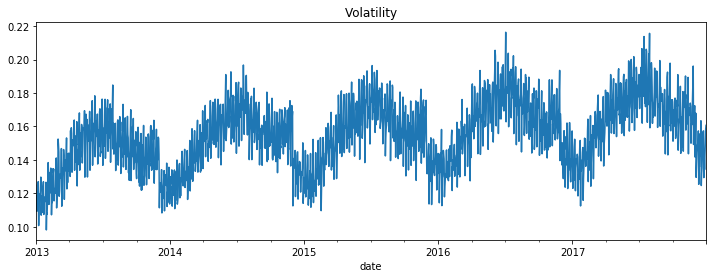

In [19]:
# First lets normalize the season dataframe by item and store
season_dftrain['sales'] = season_dftrain['sales'] / season_dftrain.groupby(['item', 'store'])['sales'].transform('mean')

# Now lets plot it
_ = season_dftrain.groupby(['date'])['sales'].std().plot(figsize=(12,4), title='Volatility')

### Considerations

Even tho the data having a constant variance and autocorrelation, there is a trend and seasonality, and thus it can be considered as non-stationary. A adfuller test could be used to comprove it in addition to visualization.

In [20]:
# Importing the necessary library
from statsmodels.tsa.stattools import adfuller

results = adfuller(pd.pivot_table(season_dftrain, values='sales', index='Year'))
print('ADF Statistic: ', results[0])
print('p-value: ', results[1])
print('Critical Values: ')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic:  -1.911190230333674
p-value:  0.3268153233606392
Critical Values: 
	1%: -7.355
	5%: -4.474
	10%: -3.127


The p-value is greater than 0.05, which fails to reject the null hypotheses and so the data has a unit root and is non-stationary.

All considered, we are going for a __SARIMA model__.
***

## Data preparation

### Make it stationary

To use the SARIMA model the data must be stationary, so, lets create a new dataset with the difference between each time in our time series and the previous value.

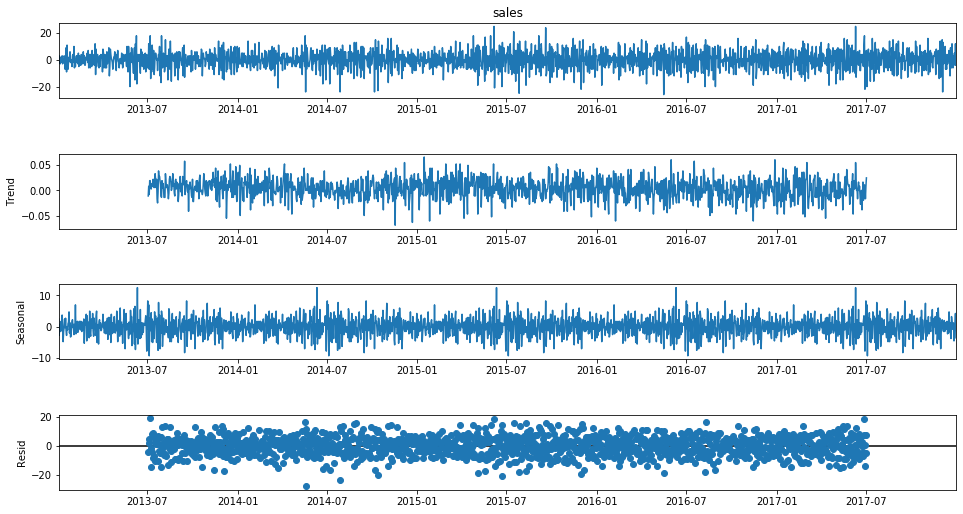

In [21]:
aux_stationary = aux.diff().dropna()
sd_stationary = sm.tsa.seasonal_decompose(aux_stationary.sales.dropna(), period=365)
fig = sd_stationary.plot()
fig.set_figheight(8)
fig.set_figwidth(15)

### Train & test data split (using df_train)

In [22]:
# Define train and test period
train_start, train_end = '2014-01-01', '2017-09-30'
test_start, test_end = '2017-10-01', '2017-12-31'

train = aux['sales'][train_start:train_end].dropna()
test = aux['sales'][test_start:test_end].dropna()
train_stat = aux_stationary['sales'][train_start:train_end].dropna()
test_stat = aux_stationary['sales'][test_start:test_end].dropna()

### Correlograms

In order to get some parameters for our model lets use ACF and PACF.

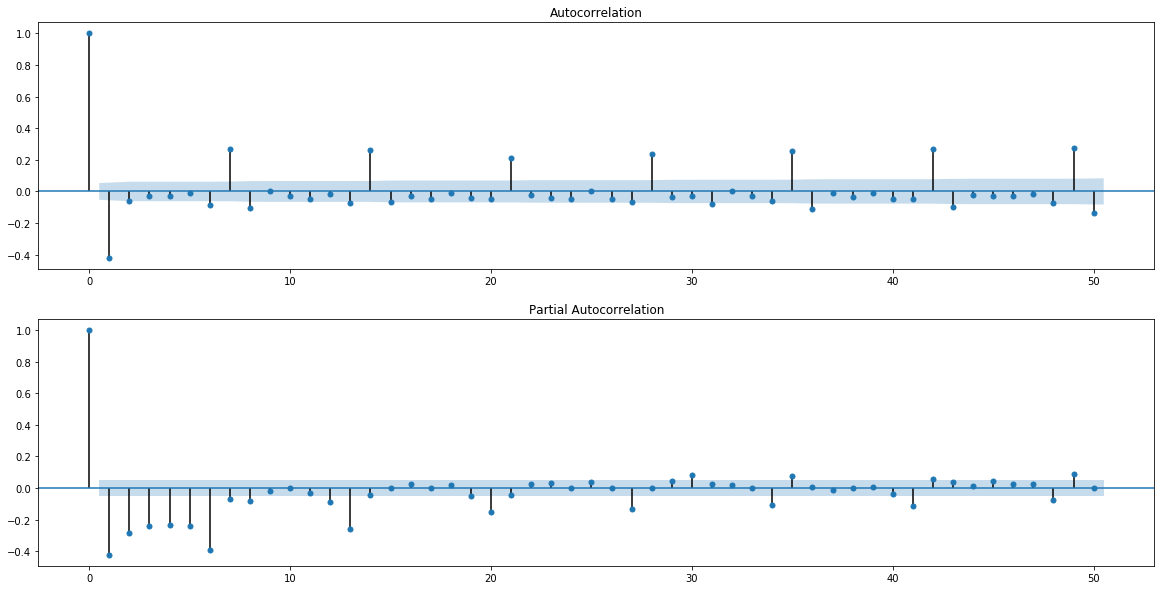

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
_ = sm.graphics.tsa.plot_acf(train_stat, lags=50, ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(train_stat, lags=50, ax=ax[1])

By plotting the correlograms it's visible that it is a ARMA model and so lets use arma_order_select_ic method to search for the best parameters

In [24]:
params = sm.tsa.arma_order_select_ic(train, max_ar=7, max_ma=7, ic='aic', trend='c')

C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Converg

In [25]:
print('(p, q) =', params['aic_min_order'])


(p, q) = (7, 7)


***
## Modeling

### Model performance

Considering the problem and the model the Mean Squared Error is going to be the model evaluator:
\begin{equation*}
MSE = \frac{1}{N} \sum_{i=1}^N (Y_i - \hat{Y_i})^{2}
\end{equation*}

### SARIMA implementation

In [27]:
# Define a 12 seasonal_order since it's running in a local pc with medium specs.
# The train order was defined by the p e q estimated
# Frequency is based in the dataset, which comes by day and has every day
sarima = sm.tsa.statespace.SARIMAX(train,order=(7,1,7),seasonal_order=(7,1,7,12), enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarima.summary()

C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\guilh\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1369
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 12)   Log Likelihood               -3830.340
Date:                            Fri, 23 Oct 2020   AIC                           7718.681
Time:                                    19:33:13   BIC                           7867.800
Sample:                                01-01-2014   HQIC                          7774.709
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7266      0.124     -5.848      0.000      -0.970      -0.483
ar.L2         -0.8131      0.054    -15.057      0.000      -0.919      -0.707
ar.L3         -0.8240      0.101     -8.132      0.000      -1.023      -0.625
ar.L4         -0.7147      0.091     -7.833      0.000      -0.894      -0.536
ar.L5         -0.8954      0.064    -13.935      0.000      -1.021      -0.769
ar.L6         -0.6752      0.120     -5.629      0.000      -0.910      -0.440
ar.L7          0.1082      0.038      2.854      0.004       0.034       0.183
ma.L1         -0.1311      0.123     -1.064      0.287      -0.373       0.110
ma.L2          0.1730      0.099      1.750      0.080      -0.021       0.367
ma.L3          0.0642      0.095      0.678      0.498      -0.121       0.250
ma.L4         -0.0600      0.082     -0.734      0.463      -0.220       0.100
ma.L5          0.3021      0.083      3.641      0.000       0.139       0.465
ma.L6         -0.1774      0.107     -1.657      0.098      -0.387       0.032
ma.L7         -0.6297      0.103     -6.118      0.000      -0.831      -0.428
ar.S.L12      -0.9551      0.281     -3.400      0.001      -1.506      -0.405
ar.S.L24      -0.7933      0.285     -2.781      0.005      -1.352      -0.234
ar.S.L36      -0.7695      0.211     -3.653      0.000      -1.182      -0.357
ar.S.L48      -0.7100      0.185     -3.838      0.000      -1.073      -0.347
ar.S.L60      -0.5502      0.195     -2.826      0.005      -0.932      -0.169
ar.S.L72      -0.4222      0.139     -3.042      0.002      -0.694      -0.150
ar.S.L84      -0.0281      0.031     -0.908      0.364      -0.089       0.033
ma.S.L12      -0.0303      0.295     -0.103      0.918      -0.609       0.548
ma.S.L24      -0.1646      0.224     -0.735      0.462      -0.603       0.274
ma.S.L36      -0.1051      0.205     -0.514      0.607      -0.506       0.296
ma.S.L48      -0.0890      0.173     -0.514      0.607      -0.428       0.250
ma.S.L60      -0.1460      0.137     -1.064      0.287      -0.415       0.123
ma.S.L72      -0.1229      0.141     -0.871      0.384      -0.399       0.154
ma.S.L84      -0.3539      0.139     -2.551      0.011      -0.626      -0.082
sigma2        23.9515      2.522      9.495      0.000      19.008      28.896
===================================================================================
Ljung-Box (Q):                       36.09   Jarque-Bera (JB):                 4.88
Prob(Q):                              0.65   Prob(JB):                         0.09
Heteroskedasticity (H):               1.23   Skew:                             0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now lets check the model's quality by plotting its resid's autocorrelation.

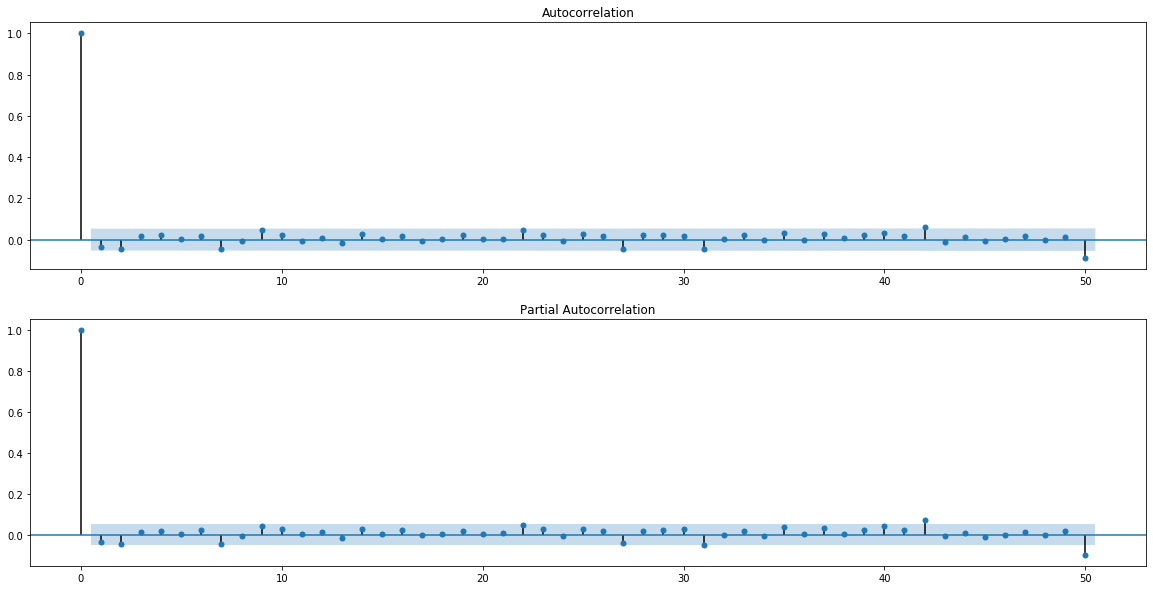

In [29]:
# Taking the resid
resid = sarima.resid

fig, ax = plt.subplots(2, 1, figsize=(20,10))
_ = sm.graphics.tsa.plot_acf(resid, lags=50, ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(resid, lags=50, ax=ax[1])

There's a few autocorrelation, which implies in a good model. To confirm it lets now predict the test set and calculate the MSE for the test set. But before lets use the .plot_diagnostics method in the sarima variable to get some informations.

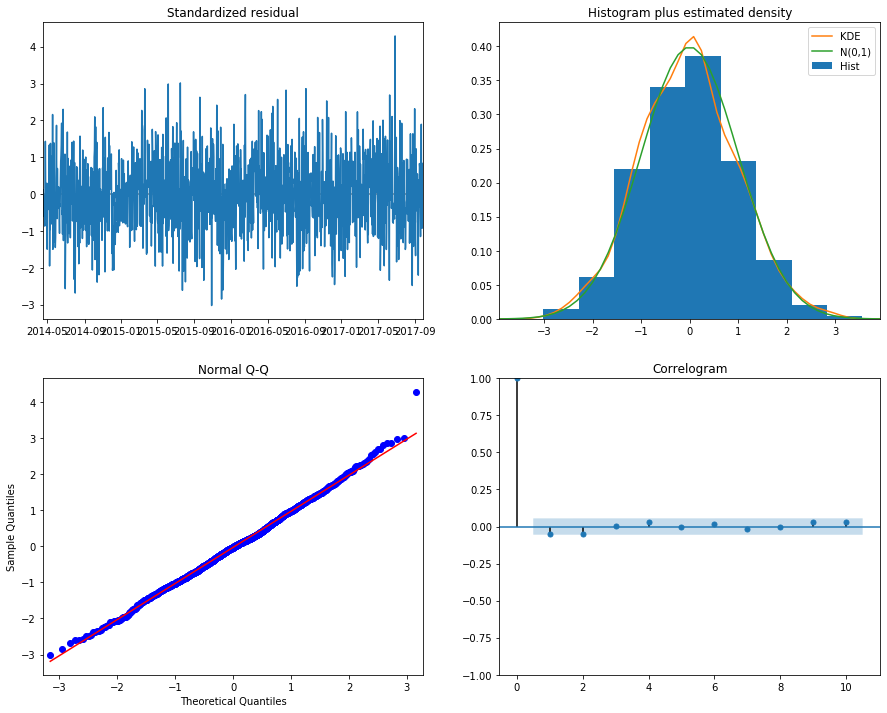

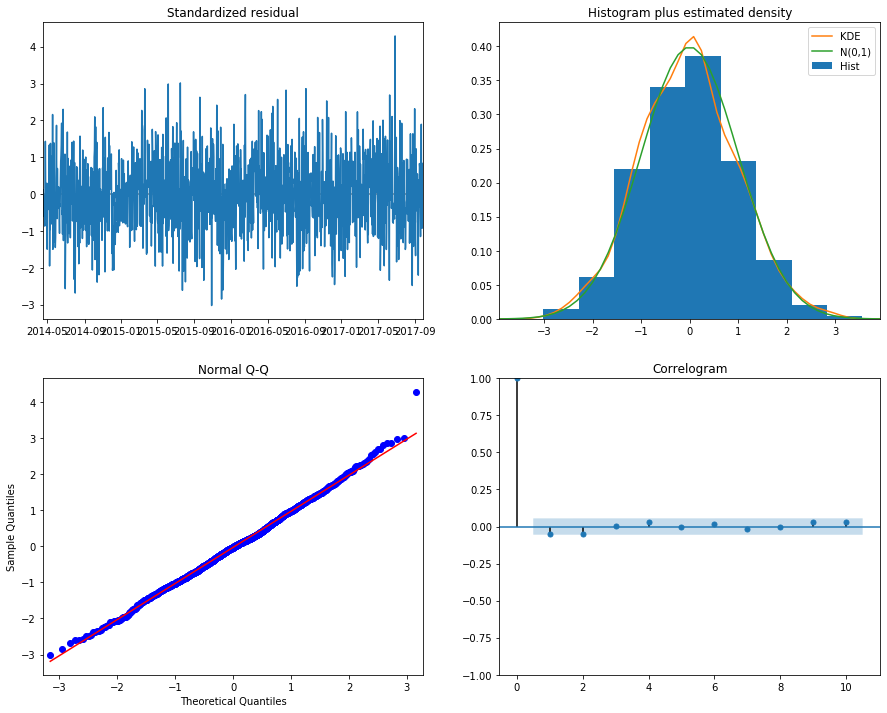

In [44]:
sarima.plot_diagnostics(figsize=(15,12))

Now the MSE

MSE:52.236034062595


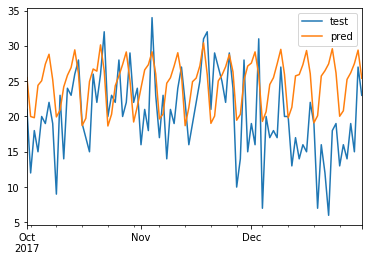

In [43]:
# Importing the necessary library
from sklearn.metrics import mean_squared_error

pred = sarima.predict(train_end, test_end)[1:]
print('MSE:{}'.format(mean_squared_error(test, pred)))

# Plotting them together with legend
pd.DataFrame({'test': test, 'pred':pred}).plot()

The MSE is very high and I could go for some data manipulations in order to create new features or tune the parameters. One way to improve the orders, for example, is using the pmdarima library. Another way is to create a method that goes over different combinations until find the best fit (using itertools and looking for a lower MSE).

Remembering that all this was applied for item = 1 and store = 1. So, in order to predict and build the submition file its necessary to loop over all combinations. Unfortunately it consumes a lot of time using the current machine.